# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activations, optimizers)
### LECTURE: Optimizers comparison
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-0f113f8f2fea>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

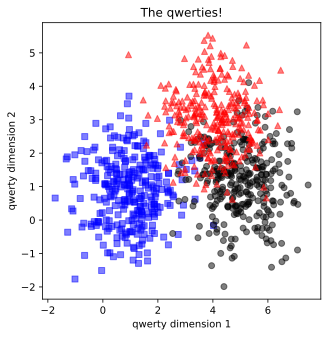

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
# how many batches are there?

print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

There are 50 batches, each with 16 samples.


# The model

In [5]:
# create a class for the model
def createTheQwertyNet(optimizerAlgo, lr):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=lr)

  return net,lossfun,optimizer


In [6]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQwertyNet('RMSprop',0.01)[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

# A function that trains the model

In [7]:
def funtion2trainTheModel(optimizerType, lr):

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType, lr)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# A function that plots the results

In [8]:
# a function that plots the results
def plotTheResults(optimizerType):

  # compute accuracy over entire dataset (train+test)
  yHat = net(data)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()
  totalAcc = torch.mean(100*accuracy).item()

  # and accuracy by group
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


  # create the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))

  # plot the loss function
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title(f'{optimizerType}: Losses')

  # plot the accuracy functions
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title(f'{optimizerType}: Accuracy')
  ax[0,1].legend()

  # plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title(f'{optimizerType}: Accuracy by group')

  # scatterplot of correct and incorrect labeled data
  colorShapes = [ 'bs','ko','g^' ] # data markers
  for i in range(3):
    # plot all data points
    ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')

    # cross-out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')

  ax[1,1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()

  plt.tight_layout()
  plt.show()

# Now for the optimizer comparison

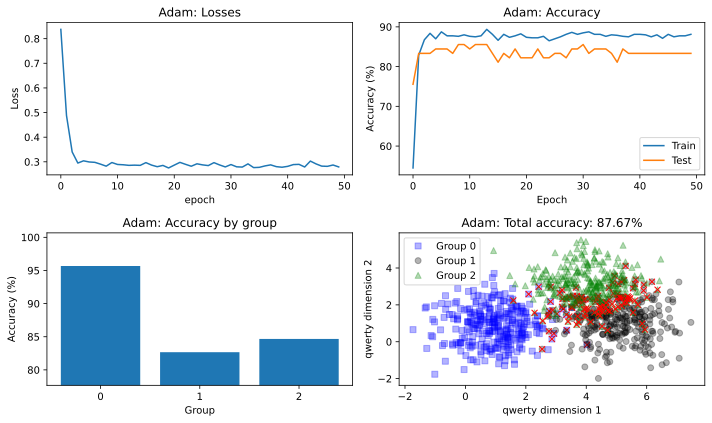

In [9]:
# run the model for one optimizer
optimizerType = 'Adam'
trainAcc,testAcc,losses,net = funtion2trainTheModel(optimizerType, 0.01)

# visualize!
plotTheResults(optimizerType)

In [13]:
np.logspace(-4,1,20)

array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])

In [14]:
np.logspace(np.log10(0.0001), np.log10(0.1), 20)

array([1.00000000e-04, 1.43844989e-04, 2.06913808e-04, 2.97635144e-04,
       4.28133240e-04, 6.15848211e-04, 8.85866790e-04, 1.27427499e-03,
       1.83298071e-03, 2.63665090e-03, 3.79269019e-03, 5.45559478e-03,
       7.84759970e-03, 1.12883789e-02, 1.62377674e-02, 2.33572147e-02,
       3.35981829e-02, 4.83293024e-02, 6.95192796e-02, 1.00000000e-01])

In [19]:
# variables to loop over
learningRates = np.logspace(np.log10(.0001),np.log10(.1),20)
optimTypes = ['SGD','RMSprop','Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates),len(optimTypes)))


# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
  for idx_l,lr in enumerate(learningRates):
    trainAcc,testAcc,losses,net = funtion2trainTheModel(opto,lr)
    finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])

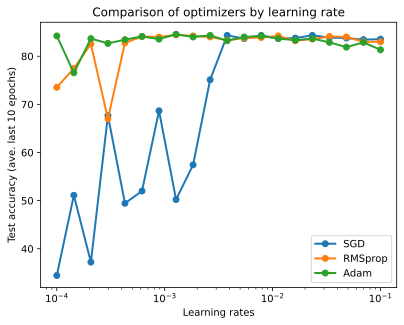

In [21]:
# plot the results!
plt.plot(learningRates,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

In [17]:
# now run through all of them

# average performance
lrs = np.logspace(-4, 1, 20) #logrithmically spaced learning rates - np.logspace(start exp, end exp, quantity)
opto_types= ['SGD','RMSprop','Adam']

sgd_performance = np.zeros(len(lrs))
rms_performance = np.zeros(len(lrs))
adam_performance = np.zeros(len(lrs))
for i, lr in enumerate(lrs):
  for opto in opto_types:
    print(lr, opto)
    trainAcc,testAcc,losses,net = funtion2trainTheModel(opto, lr)
    if opto == 'SGD':
      sgd_performance[i] = np.mean(testAcc[-10:])
    elif opto == 'RMSprop':
      rms_performance[i] = np.mean(testAcc[-10:])
    elif opto == 'Adam':
      adam_performance[i] = np.mean(testAcc[-10:])


9.999999999999999e-05 SGD
9.999999999999999e-05 RMSprop
9.999999999999999e-05 Adam
0.00018329807108324357 SGD
0.00018329807108324357 RMSprop
0.00018329807108324357 Adam
0.0003359818286283781 SGD
0.0003359818286283781 RMSprop
0.0003359818286283781 Adam
0.0006158482110660266 SGD
0.0006158482110660266 RMSprop
0.0006158482110660266 Adam
0.0011288378916846883 SGD
0.0011288378916846883 RMSprop
0.0011288378916846883 Adam
0.00206913808111479 SGD
0.00206913808111479 RMSprop
0.00206913808111479 Adam
0.00379269019073225 SGD
0.00379269019073225 RMSprop
0.00379269019073225 Adam
0.0069519279617756054 SGD
0.0069519279617756054 RMSprop
0.0069519279617756054 Adam
0.012742749857031334 SGD
0.012742749857031334 RMSprop
0.012742749857031334 Adam
0.023357214690901212 SGD
0.023357214690901212 RMSprop
0.023357214690901212 Adam
0.04281332398719391 SGD
0.04281332398719391 RMSprop
0.04281332398719391 Adam
0.07847599703514606 SGD
0.07847599703514606 RMSprop
0.07847599703514606 Adam
0.14384498882876628 SGD
0.14384

In [22]:
sgd_performance

array([52.11110687, 35.55555344, 19.00000191, 45.66666794, 50.88888931,
       73.22222137, 82.22221375, 84.33332825, 83.55554962, 83.55555725,
       84.        , 83.33332825, 82.55554962, 83.8888855 , 81.55555725,
       33.44445038, 32.55555344, 33.22222519, 35.        , 34.44444656])

In [26]:
finalPerformance[:,0]

array([34.44445038, 51.1111145 , 37.22222137, 67.66667175, 49.44444656,
       52.        , 68.66667175, 50.22222137, 57.44445038, 75.11110687,
       84.33333588, 83.66666412, 84.33332825, 83.66666412, 83.77777863,
       84.33332825, 83.8888855 , 83.777771  , 83.44444275, 83.55555725])

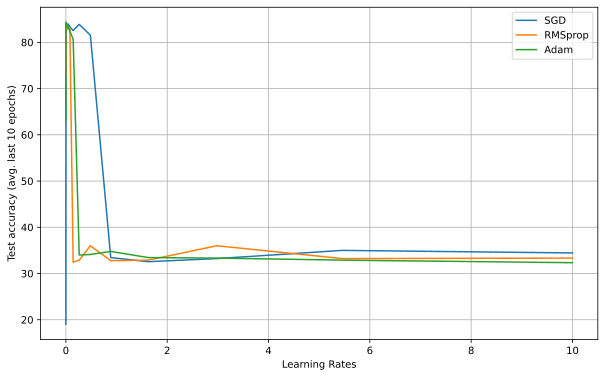

In [20]:
plt.figure(figsize= (10,6))
plt.plot(lrs, sgd_performance, label="SGD")
plt.plot(lrs, rms_performance, label="RMSprop")
plt.plot(lrs, adam_performance, label="Adam")
plt.xlabel("Learning Rates")
plt.ylabel("Test accuracy (avg. last 10 epochs)")
plt.legend() #['SGD','RMSprop','Adam']
plt.grid()
plt.show()

# Additional explorations

In [12]:
# 1) Accuracy seems to be different between the different qwerties categories. Is this consistent across the optimizers?
#    Or does it seem like some optimizers are better at some categories? How do you interpret your answer, and what does
#    it indicate about metaparameters of DL and their effects on performance?
#
# 2) The results here indicate that all three optimizers perform roughly equally well, but SGD needs more training. Is
#    that still the case with a smaller or larger learning rate?
#
# 3) The method of showing the final performance (printing out a list) is... not very pretty. What kind of visualization
#    do you think would better illustrate the performances across the optimizers? Code it!
#